<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Fine_tuning_LayoutLMForTokenClassification_on_FUNSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318

* Original FUNSD paper: https://arxiv.org/abs/1905.13538


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [1]:
%%bash
unilm="$HOME/git-repos/NielsRogge/unilm"
if [ ! -d "$unilm" ]; then
    echo "Repo $unilm not exist yet. Downloading into $unilm" && \
    mkdir -p $(dirname $unilm) && \
    git clone -b remove_torch_save \
    https://github.com/NielsRogge/unilm.git $unilm
else
    echo "Repo $unilm already exists."
fi

Repo /home/phunc20/git-repos/NielsRogge/unilm already exists.


In [2]:
!echo "$unilm"

> Shell variables defined in one cell are **forgotten** in subsequent cells.

Let's define the `unilm` path in Python instead. Recall that in bash cells, Python variables are referred to by surrounding them with _curly braces_ `{}`.

In [3]:
from pathlib import Path
unilm = Path.home() / "git-repos/NielsRogge/unilm"
unilm

PosixPath('/home/phunc20/git-repos/NielsRogge/unilm')

In [4]:
# Install layoutlm if not already installed
!pip list | grep layoutlm > /dev/null && printf "\n{unilm} already pip install'ed\n"


/home/phunc20/git-repos/NielsRogge/unilm already pip install'ed


In [5]:
!pip list | grep layoutlm > /dev/null || pip install -e "{unilm}/layoutlm"

Next we do the same for `huggingface`'s `transformers` package.

In [6]:
transformers = Path.home() / "git-repos/huggingface/transformers"
transformers

PosixPath('/home/phunc20/git-repos/huggingface/transformers')

We don't use `%%bash` magic in the next cell because
> Even Python variable cannot be read in a `%%bash` cell. On the contrary, a one-liner bash command is aware of the existence of all Python variables (in `globals()`)

In [7]:
![ ! -d "{transformers}" ] && \
    echo "Repo {transformers} NOT exist YET. Downloading..." && \
    mkdir -p $(dirname "{transformers}") && \
    git clone https://github.com/huggingface/transformers.git \
              "{transformers}" && \
    pip install "{transformers}"

The next cell is not necessary because future import will _simply overwrite the variable names_.

## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called being created (under the path `~/datasets/ocr/funsd`), which contains 2 subdirectories, one for training and the other for testing. Each of these has 2 subfolders again

- `images/` contains the PNG image files
- `annotations` contains the annotations in JSON format

```bash
tree -L 3 ~/datasets/ocr/funsd
/home/phunc20/datasets/ocr/funsd
└── dataset
    ├── testing_data
    │   ├── annotations
    │   └── images
    └── training_data
        ├── annotations
        └── images
   
7 directories, 0 files
```

In [8]:
from pathlib import Path
path_dataset_download = Path.home() / "datasets/ocr/funsd/"
if not path_dataset_download.exists():
    path_dataset_download.mkdir(parents=True)

path_zip = path_dataset_download / "dataset.zip"
path_dataset = path_zip.parent / path_zip.stem

! [ ! -d {path_dataset} ] && \
    wget https://guillaumejaume.github.io/FUNSD/dataset.zip \
    -P {path_dataset_download}

In [9]:
if path_zip.exists():
    if not path_dataset.is_dir():
        !unzip -d "{path_dataset_download}" "{path_zip}"
    path_zip.unlink()
    !rm -r {path_dataset_download}/__MACOSX

Let's take a look at a training example. For this, we are going to use `PIL`.

In [60]:
from PIL import Image, ImageDraw, ImageFont

demo_id = "0000971160"
image = Image.open(path_dataset/f"training_data/images/{demo_id}.png")
image.mode

'L'

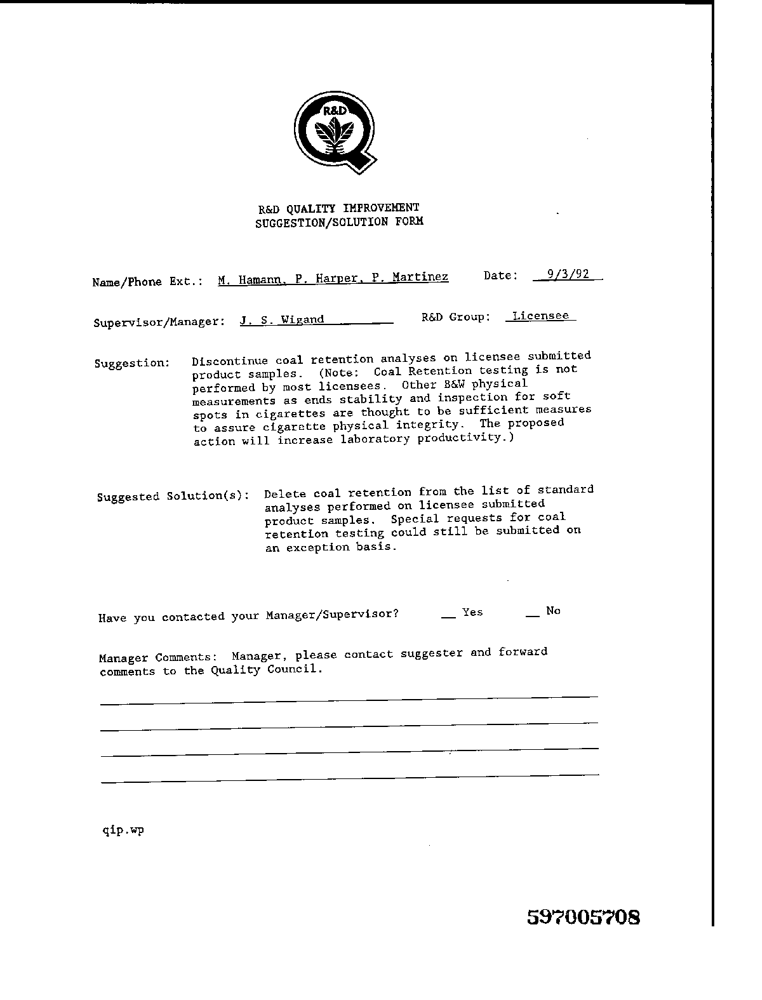

In [61]:
image = image.convert("RGB")
image

Now let's draw its annotations. Basically, if you type `data['form']` (cf. below), you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in turn also have their own bounding boxes. The bounding boxes are in
```
[topleft_x, topleft_y, bottomright_x, bottomright_y]
```
 format.

In [12]:
import json
import pprint

with open(path_dataset/'training_data/annotations/{demo_id}.json') as f:
    data = json.load(f)

for i, annotation in enumerate(data['form']):
    if i > 2:
        break
    pprint.pprint(annotation)
    print()

{'box': [292, 91, 376, 175],
 'id': 0,
 'label': 'other',
 'linking': [],
 'text': 'R&D',
 'words': [{'box': [292, 91, 376, 175], 'text': 'R&D'}]}

{'box': [219, 316, 225, 327],
 'id': 1,
 'label': 'question',
 'linking': [],
 'text': ':',
 'words': [{'box': [219, 316, 225, 327], 'text': ':'}]}

{'box': [95, 355, 169, 370],
 'id': 2,
 'label': 'question',
 'linking': [[2, 16]],
 'text': 'Suggestion:',
 'words': [{'box': [95, 355, 169, 370], 'text': 'Suggestion:'}]}



In [13]:
data.keys()

dict_keys(['form'])

In [14]:
type(data["form"])

list

In [15]:
len(data["form"])

24

In [16]:
data["form"][0]

{'box': [292, 91, 376, 175],
 'text': 'R&D',
 'label': 'other',
 'words': [{'box': [292, 91, 376, 175], 'text': 'R&D'}],
 'linking': [],
 'id': 0}

The PIL library has a handy ImageDraw module, which, you guessed it, allows to draw things (such as rectangles) on an image:

In [17]:
draw = ImageDraw.Draw(image, "RGBA")
font = ImageFont.load_default()
draw, font

(<PIL.ImageDraw.ImageDraw at 0x7f3e5450e390>,
 <PIL.ImageFont.ImageFont at 0x7f3e5450e450>)

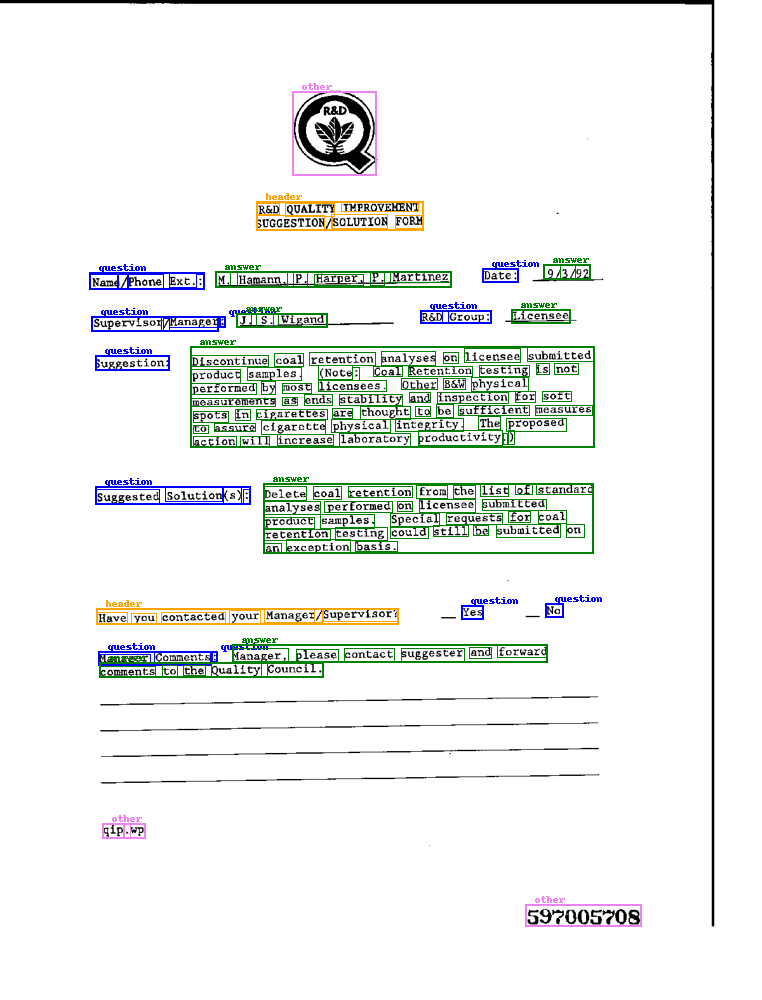

In [23]:
label2color = {'question':'blue',
               'answer':'green',
               'header':'orange',
               'other':'violet',
              }

for annotation in data['form']:
    label = annotation['label']
    general_box = annotation['box']
    draw.rectangle(general_box, outline=label2color[label], width=2)
    draw.text(
        (general_box[0] + 10, general_box[1] - 10),
        label,
        fill=label2color[label], 
        font=font,
    )
    words = annotation['words']
    for word in words:
        box = word['box']
        # finer: width=1
        draw.rectangle(box, outline=label2color[label], width=1)

image

Let's recall what our annotations look like:

In [28]:
for i, annotation in enumerate(data['form'][10:16]):
    pprint.pprint(annotation)
    print()

{'box': [89, 272, 204, 289],
 'id': 10,
 'label': 'question',
 'linking': [[10, 11]],
 'text': 'Name / Phone Ext. :',
 'words': [{'box': [89, 274, 118, 289], 'text': 'Name'},
           {'box': [117, 274, 127, 288], 'text': '/'},
           {'box': [128, 274, 163, 289], 'text': 'Phone'},
           {'box': [169, 272, 196, 287], 'text': 'Ext.'},
           {'box': [196, 274, 204, 288], 'text': ':'}]}

{'box': [215, 271, 451, 287],
 'id': 11,
 'label': 'answer',
 'linking': [[10, 11]],
 'text': 'M. Hamann P. Harper, P. Martinez',
 'words': [{'box': [215, 272, 230, 287], 'text': 'M.'},
           {'box': [237, 272, 287, 286], 'text': 'Hamann'},
           {'box': [293, 272, 307, 286], 'text': 'P.'},
           {'box': [314, 274, 363, 285], 'text': 'Harper,'},
           {'box': [370, 272, 384, 285], 'text': 'P.'},
           {'box': [390, 271, 451, 282], 'text': 'Martinez'}]}

{'box': [543, 264, 590, 279],
 'id': 12,
 'label': 'answer',
 'linking': [[3, 12]],
 'text': '9/ 3/ 92',
 'words'

Note that the `"linking"`'s value is sometimes an empyt list, sometime an non-empty list. When it is non-empty, it gives information on _"to which annotation (id) it is related"_.

- Stopped here (2021/07/21 (水))
- Stopped here (2021/08/06 (金))

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [31]:
unilm

PosixPath('/home/phunc20/git-repos/NielsRogge/unilm')

In [33]:
!ls {unilm}/layoutlm/examples/seq_labeling

preprocess.py  preprocess.sh  run_seq_labeling.py


**(?)** Why not `--max_len 512` but `510`?

The two commands above runs the Python scripts `{unilm}/layoutlm/examples/seq_labeling/preprocess.py` generate the following text files in `path_dataset`

- `{train,test}_box.txt{,.tmp}`
- `{train,test}_image.txt{,.tmp}`
- `{train,test}.txt{,.tmp}`

In [34]:
!ls {path_dataset}

labels.txt	  test_image.txt.tmp  train_box.txt	   training_data
test_box.txt	  testing_data	      train_box.txt.tmp    train.txt
test_box.txt.tmp  test.txt	      train_image.txt	   train.txt.tmp
test_image.txt	  test.txt.tmp	      train_image.txt.tmp


Next, we create a `labels.txt` file that contains the unique labels of the FUNSD dataset:

In [36]:
!head -20 {path_dataset}/train.txt

Date:	S-QUESTION
3/27/84	S-ANSWER
84-C-7	O
Cicarettes	S-HEADER
Filters	O
BLEND	S-QUESTION
CASING	S-QUESTION
RECASING	S-QUESTION
1077-84	S-ANSWER
7773	S-ANSWER
7774	S-ANSWER
attached	S-ANSWER
Maker	S-QUESTION
Length	S-QUESTION
Filter	S-QUESTION
Length	S-QUESTION
Circumference	S-QUESTION
Weight	S-QUESTION
Paper	S-QUESTION
MENTHOL	S-QUESTION


Note that in the following linux commands, there is a particularity

```bash
cut -d$'\t' -f 2
```

This is simply saying that it wants the delimiter to be `<Tab>` (and it takes the 2nd field). Since by default the `cut` command presumes the delimiter to be `<Tab>`, we actually have a simpler way to do exactly the same thing

```bash
cut -f 2
```

This way of writing is called _ANSI-C quoting_. Readers unaware of and wanting to know more about it can refer to

- <https://unix.stackexchange.com/questions/35369/how-to-define-tab-delimiter-with-cut-in-bash>
- <https://www.gnu.org/software/bash/manual/html_node/ANSI_002dC-Quoting.html>

```bash
[phunc20@homography-x220t LayoutLM]$ echo '\t' | wc --chars
3
[phunc20@homography-x220t LayoutLM]$ echo $'\t' | wc --chars
2
```

ANSI-C quoting sounds technical. In simpler terms, it just means that

- In Linux shell, the string `"\t"` is considered as a string composed of two characters `'\'` and `'t'`
- To have Linux admit that `'\t'`, one adds the prefix `$`, as in `$'\t'`.

In [44]:
!echo '\t' | wc --chars

3


In [45]:
!echo $'\t' | wc --chars

2


Note that

- the above stdout looks a little weird at first glance; after one second of reflection, one gets the picture
  > The `echo` command automatically append a newline character `'\n'` at the end, which is why the stdout's number seems to be `1` greater than what one expects
- there is _diff btw using **single quotes** and **double quotes**_! Cf. below

In [50]:
!echo "\t" | wc --chars

3


In [51]:
!echo $"\t" | wc --chars

3


In [40]:
!cat {path_dataset}/train.txt | cut -d$'\t' -f 2 | \
    grep -v "^$"| sort | uniq

B-ANSWER
B-HEADER
B-QUESTION
E-ANSWER
E-HEADER
E-QUESTION
I-ANSWER
I-HEADER
I-QUESTION
O
S-ANSWER
S-HEADER
S-QUESTION


In [53]:
! [ -f {path_dataset}/labels.txt ] && printf "labels.txt exists ALREADY"

labels.txt exists ALREADY

In [54]:
! [ -f {path_dataset}/labels.txt ] || \
    cat {path_dataset}/train.txt | cut -d$'\t' -f 2 | \
    grep -v "^$"| sort | uniq > {path_dataset}/labels.txt

- Stopped here (2021/07/22 (木) 18h17)

## Define a PyTorch dataset

First, we create a list containing the unique labels based on `{path_dataset}/labels.txt`.

In [55]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels(f"{path_dataset}/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
label_map

{0: 'B-ANSWER',
 1: 'B-HEADER',
 2: 'B-QUESTION',
 3: 'E-ANSWER',
 4: 'E-HEADER',
 5: 'E-QUESTION',
 6: 'I-ANSWER',
 7: 'I-HEADER',
 8: 'I-QUESTION',
 9: 'O',
 10: 'S-ANSWER',
 11: 'S-HEADER',
 12: 'S-QUESTION'}

In [56]:
!wc -l {path_dataset}/labels.txt

13 /home/phunc20/datasets/ocr/funsd/dataset/labels.txt


In [57]:
# Use cross entropy ignore index as padding label id so that
# only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index
pad_token_label_id

-100

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

**(?)** Please draw the BIOES on a certain image (visualization) to make it clearer as to what each of `B, I, O, E, S` means.<br>
**(R)** Let's do this step by step. Assume that we are going to do this for the same image with `demo_id` (defined earlier).

Firstly, there is no single file which aggregate the necessary information to do this. We can combine the information in the following two files to achieve this:

- `train_image.txt`
- `train.txt`


Since these files contain the same number of lines and put the information in the same order, let's extract the line number concerning the image that we are interested in, i.e. `demo_id`.

In [79]:
demo_id

'0000971160'

In [78]:
!wc -l {path_dataset}/train.txt
!wc -l {path_dataset}/train_image.txt
!wc -l {path_dataset}/train_box.txt

22038 /home/phunc20/datasets/ocr/funsd/dataset/train.txt
22038 /home/phunc20/datasets/ocr/funsd/dataset/train_image.txt
22038 /home/phunc20/datasets/ocr/funsd/dataset/train_box.txt


In [62]:
!grep -n "0000971160.png" "{path_dataset}/train_image.txt" | (head -n1 && tail -n1)

9406:R&D	292 91 376 175	762 1000	0000971160.png
9550:wp	130 823 145 837	762 1000	0000971160.png


So the related lines are _from 9406 to 9550_.

In [87]:
import pandas as pd

In [103]:
start_row = 9406 - 1
stop_row = 9550
skip_rows = list(range(start_row)) + list(range(stop_row, 22038))
demo_df = pd.read_csv(
    path_dataset / "train_image.txt",
    delimiter="\t",
    names=["text", "bbox", "dimension", "filename"],
    skiprows=skip_rows,
)

demo_df

,text,bbox,dimension,filename
0,performed,190 383 256 394,762 1000,0000971160.png
1,by,261 381 275 394,762 1000,0000971160.png
2,most,282 383 311 393,762 1000,0000971160.png
3,licensees.,318 380 386 391,762 1000,0000971160.png
4,Other,401 378 437 389,762 1000,0000971160.png
...,...,...,...,...
139,representing,601 214 713 232,780 1000,92433599_92433601.png
140,claimant:,162 232 244 249,780 1000,92433599_92433601.png
141,"BRAYTON,",236 263 310 278,780 1000,92433599_92433601.png
142,GISVOLD.,320 261 388 276,780 1000,92433599_92433601.png


Nah, I am being stupid. Let's forget about which row is which. Let's load the whole CSV file and then _filter_.

In [134]:
train_image_df = pd.read_csv(
    path_dataset / "train_image.txt",
    delimiter="\t",
    names=["text", "bbox", "dimension", "filename"],
    usecols=["text", "bbox", "filename"],
)

train_image_df

,text,bbox,filename
0,Date:,485 32 526 49,81574683.png
1,3/27/84,531 32 585 49,81574683.png
2,84-C-7,634 34 683 48,81574683.png
3,Cicarettes,31 218 111 236,81574683.png
4,Filters,320 221 377 238,81574683.png
...,...,...,...
21742,until,462 835 507 846,0060036622.png
21743,Committee,372 863 447 877,0060036622.png
21744,meeting,454 863 515 877,0060036622.png
21745,8/,561 834 582 876,0060036622.png


In [135]:
train_df = pd.read_csv(
    path_dataset / "train.txt",
    delimiter="\t",
    names=["text", "label"],
)
train_df

,text,label
0,Date:,S-QUESTION
1,3/27/84,S-ANSWER
2,84-C-7,O
3,Cicarettes,S-HEADER
4,Filters,O
...,...,...
21742,until,E-QUESTION
21743,Committee,B-QUESTION
21744,meeting,E-QUESTION
21745,8/,B-ANSWER


In [111]:
train_df.dtypes

text     object
label    object
dtype: object

In [112]:
train_image_df.dtypes

text        object
bbox        object
filename    object
dtype: object

In [119]:
train_df.join(train_image_df, rsuffix='_image').head()

,text,label,text_image,bbox,filename
0,Date:,S-QUESTION,Date:,485 32 526 49,81574683.png
1,3/27/84,S-ANSWER,3/27/84,531 32 585 49,81574683.png
2,84-C-7,O,84-C-7,634 34 683 48,81574683.png
3,Cicarettes,S-HEADER,Cicarettes,31 218 111 236,81574683.png
4,Filters,O,Filters,320 221 377 238,81574683.png


In [120]:
train_df.head()

,text,label
0,Date:,S-QUESTION
1,3/27/84,S-ANSWER
2,84-C-7,O
3,Cicarettes,S-HEADER
4,Filters,O


In [132]:
train_df.shape, train_image_df.shape

((21747, 2), (21747, 3))

In [131]:
train_df.join(train_image_df, lsuffix="2")#, on="text")

,text2,label,text,bbox,filename
0,Date:,S-QUESTION,Date:,485 32 526 49,81574683.png
1,3/27/84,S-ANSWER,3/27/84,531 32 585 49,81574683.png
2,84-C-7,O,84-C-7,634 34 683 48,81574683.png
3,Cicarettes,S-HEADER,Cicarettes,31 218 111 236,81574683.png
4,Filters,O,Filters,320 221 377 238,81574683.png
...,...,...,...,...,...
21742,until,E-QUESTION,until,462 835 507 846,0060036622.png
21743,Committee,B-QUESTION,Committee,372 863 447 877,0060036622.png
21744,meeting,E-QUESTION,meeting,454 863 515 877,0060036622.png
21745,8/,B-ANSWER,8/,561 834 582 876,0060036622.png


In [126]:
train_df.shape

(21747, 2)

Note that _because there are empty lines in these files_, the shape here is different from `22038`.

> Actually the files `{train,test}_image.txt` are organized in such a
> way that the lines are contiguous unless there is a change/jump to
> a new image filename. That is to say, the empty lines are there to
> separate the different filenames.

In [137]:
!wc -l {path_dataset}/train.txt
!grep -v "^[ \t]*$" {path_dataset}/train.txt | wc -l

22038 /home/phunc20/datasets/ocr/funsd/dataset/train.txt
21888


**(?)** Why in the world was the number `21888` above diff from `21747`, the number of rows of our DataFrames.

In [139]:
demo_df = train_df[train_image_df["filename"] == f"{demo_id}.png"].join(
    train_image_df[train_image_df["filename"] == f"{demo_id}.png"],
    lsuffix="2",
)[["text", "label", "bbox"]]
demo_df

,text,label,bbox
9286,R&D,O,292 91 376 175
9287,:,S-QUESTION,219 316 225 327
9288,Suggestion:,S-QUESTION,95 355 169 370
9289,Date:,S-QUESTION,482 268 518 282
9290,Licensee,S-ANSWER,511 309 570 323
...,...,...,...
9426,Quality,I-ANSWER,211 663 261 676
9427,Council.,E-ANSWER,267 662 323 676
9428,qip,O,102 824 123 837
9429,.,O,124 824 130 838


In [162]:
[int(n) for n in "292 91 376 175".split()]

[292, 91, 376, 175]

In [160]:
for row in demo_df.itertuples():
    text = row.text
    label = row.label
    bbox = row.bbox
    print(type(bbox))
    break

<class 'str'>


In [149]:
for i in demo_df.iterrows():
    print(i, type(i))
    print(type(i[1]))
    break

(9286, text                R&D
label                 O
bbox     292 91 376 175
Name: 9286, dtype: object) <class 'tuple'>
<class 'pandas.core.series.Series'>


In [159]:
for i in demo_df.itertuples():
    print(i, type(i))
    print(i.label)
    break

Pandas(Index=9286, text='R&D', label='O', bbox='292 91 376 175') <class 'pandas.core.frame.Pandas'>
O


In [155]:
for i in demo_df.iteritems():
    print(i)
    print(type(i))
    print(i[0])
    print(len(i))
    print(type(i[1]))
    break

('text', 9286            R&D
9287              :
9288    Suggestion:
9289          Date:
9290       Licensee
           ...     
9426        Quality
9427       Council.
9428            qip
9429              .
9430             wp
Name: text, Length: 145, dtype: object)
<class 'tuple'>
text
2
<class 'pandas.core.series.Series'>


In [166]:
"ABC".lower()

'abc'

In [206]:
font = ImageFont.load_default()
[s for s in dir(font) if not s.startswith("_")]

['font', 'getmask', 'getsize', 'info']

In [207]:
font.getsize("abc"), font.getsize("xyz")

((18, 11), (18, 11))

In [208]:
dir(font)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_pilfont',
 '_load_pilfont_data',
 'font',
 'getmask',
 'getsize',
 'info']

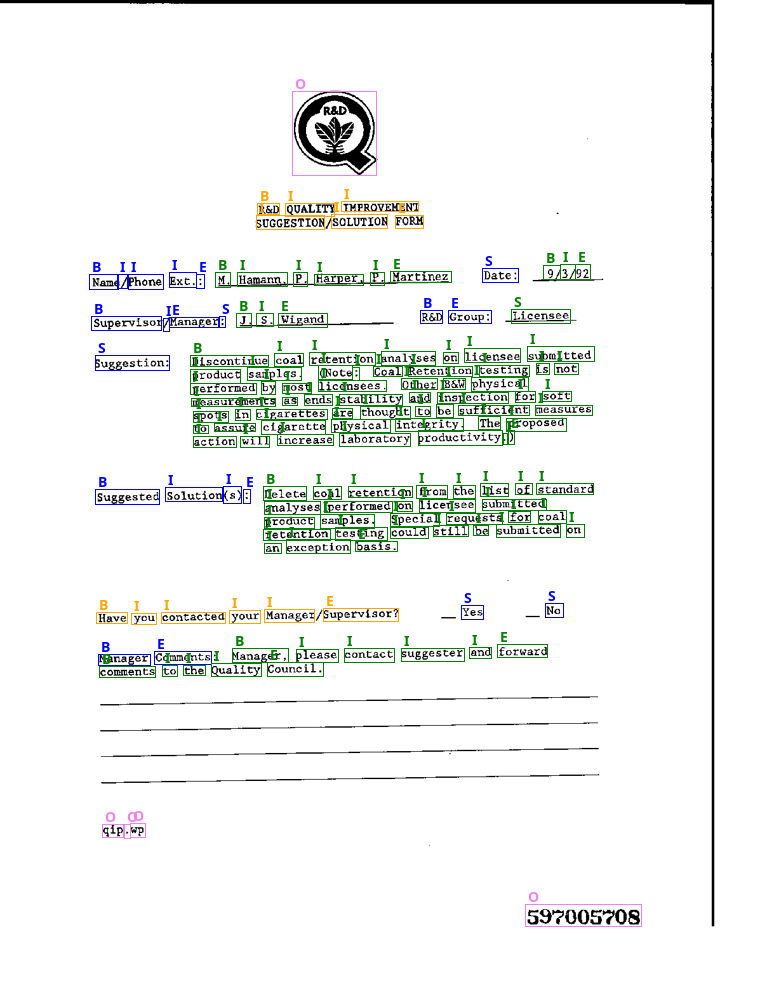

In [212]:
image = Image.open(path_dataset/f"training_data/images/{demo_id}.png").convert("RGB")
draw_BIOES = ImageDraw.Draw(image)
#font = ImageFont.load_default()
try:
    font = ImageFont.truetype(
        #"/usr/share/fonts/noto/NotoSansMono-Light.ttf",
        #"/usr/share/fonts/noto/NotoSans-BoldItalic.ttf",
        "/usr/share/fonts/noto/NotoSans-Bold.ttf",
        14,
    )
except:
    font = ImageFont.load_default()


for row in demo_df.itertuples():
    text = row.text
    label = row.label
    bbox = [int(n) for n in row.bbox.split()]
    draw_BIOES.rectangle(
        bbox,
        outline=label2color[label[2:].lower() if label != "O" else "other"],
        width=1,
    )
    draw_BIOES.text(
        (bbox[0] + 3, bbox[1] - 17),
        label[0],
        fill=label2color[label[2:].lower() if label != "O" else "other"],
        font=font,
        #stroke_width=1,
    )
    
image

Ok, I think we kind of get the meaning

> - `S` for stand-alone entities
> - `B, I, E` for words collectively composing an entity
> - `O` for `other`, i.e. none of `question, answer, header`

- Stopped here (2021/08/06 (金) 23h50)

Next, we can create a PyTorch dataset and a corresponding dataloader (both for training and evaluation):

In [59]:
args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': path_dataset,
        'model_name_or_path': 'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',
       }

print("(Before)")
print([s for s in dir(args) if not s.startswith("_")])

# class to turn the keys of a dict into attributes (thanks to stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)
print("(After)")
print([s for s in dir(args) if not s.startswith("_")])

(Before)
['clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']
(After)
['clear', 'copy', 'data_dir', 'fromkeys', 'get', 'items', 'keys', 'local_rank', 'max_seq_length', 'model_name_or_path', 'model_type', 'overwrite_cache', 'pop', 'popitem', 'setdefault', 'update', 'values']


**(?)** Try to understand how `AttrDict()` does it, if you have time.

In [213]:
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

2021-08-07 17:01:28.754734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-07 17:01:28.754767: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [214]:
tokenizer = LayoutLMTokenizer.from_pretrained(
    "microsoft/layoutlm-base-uncased"
)

**(?)** Où est stocké ce fameux tokenizer au nom de `microsoft/layoutlm-base-uncased`?

In [215]:
# the LayoutLM authors already defined a specific FunsdDataset,
# so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                             batch_size=2)

Note that we chooses

- `RandomSampler` for training
- `SequentialSampler` for evaluation/testing

which is normal, since we don't want the training result to depend on the order of the training instances.

In [216]:
len(train_dataloader)

75

In [217]:
len(eval_dataloader)

26

In [ ]:
batch = next(iter(train_dataloader))
type(batch)

In [ ]:
len(batch)

In [ ]:
[type(batch[i]) for i in range(len(batch))]

In [ ]:
[batch[i].shape for i in range(len(batch))]

**(?)** Why the last batch get to get a diff shape `[2, 512, 4]` from the others?

In [ ]:
input_ids = batch[0][0]
tokenizer.decode(input_ids)

**(?)** What is this text all about? And what does `[CLS]` mean?<br>
**(R)** It seems that `[CLS]` stands for **Classification**. For the moment, I know no more than that.

In [ ]:
tokenizer.decode(batch[0][1])

I think that

- These batches has `2` as the first number for their shapes because we have asked to `batch_size=2` in the `Dataloader`'s above
- Each instance is padded to `512`-dimensional also because we have asked for -- In the dictionary `args` defined early, we required the key-value pair `'max_seq_length': 512`

## Define and fine-tune the model
As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

**(?)** Apparently, `LayoutLM` was <del>not trained on FUNSD</del>. Then what was its training set?<br>
**(R)** It is pre-trained on the **IIT-CDIP Test Collection 1.0** dataset, and now we are training `LayoutLM` on FUNSD.

In [ ]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Now we can start training:

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5

# total number of training steps 
t_total = len(train_dataloader) * num_train_epochs

#put the model in training mode
model.train()

for epoch in range(num_train_epochs):
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        loss = outputs.loss

        # print loss every, 100, no, 50 steps
        if global_step % 50 == 0:
          print(f"Loss after {global_step} steps: {loss.item()}")

        # backward pass to get the gradients 
        loss.backward()

        #print("Gradients on classification head:")
        #print(model.classifier.weight.grad[6,:].sum())

        # update
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1

#### Stopped here (2021/07/22 (木) 18h17)

## Evaluation

Now let's evaluate on the test set:

In [ ]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

## Inference

Now comes the fun part! We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load an image from the test set, run our own OCR on it to get the bounding boxes, and then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
import pytesseract

#image = Image.open('/content/form_example.jpg')
image = Image.open("/content/data/testing_data/images/83443897.png")
image = image.convert("RGB")
image

Here we run Tesseract (an OCR engine built by Google) on the image:

In [ ]:
import numpy as np

width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

ocr_df = pytesseract.image_to_data(image, output_type='data.frame') \
            
ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df = ocr_df.dropna().reset_index(drop=True)
ocr_df[:20]

In [ ]:
len(ocr_df)

Here we create a list of words, actual bounding boxes, and normalized boxes.

In [ ]:
words = list(ocr_df.text)
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
  actual_boxes.append(actual_box)

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
boxes

This should become the future API of LayoutLMTokenizer (`prepare_for_model()`): 

In [ ]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [ ]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

In [ ]:
tokenizer.decode(input_ids)

Now let's perform a forward pass!

In [ ]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
input_ids.shape

In [ ]:
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
attention_mask.shape

In [ ]:
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
token_type_ids.shape

In [ ]:
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
bbox.shape

In [ ]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
outputs

In [ ]:
outputs.logits.shape

In [ ]:
outputs.logits.argmax(-1)

Of course, LayoutLM outputs labels at the token level, but we are interested in the predicted labels at the word level. So we should actually only incorporate the predicted labels of tokens that are the first token of a given word: 

In [ ]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    word_level_predictions.append(token_pred)
    final_boxes.append(box)

# for id, prediction in zip(input_ids.squeeze().tolist(), predictions):
#   if id != 0:
#     print(tokenizer.decode([id]), label_map[prediction])
print(word_level_predictions)

In [ ]:
print(len(word_level_predictions))

In [ ]:
print(len(final_boxes))

Let's visualize the result!

In [ ]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

Compare this to the ground truth:

In [ ]:
import json

with open('/content/data/testing_data/annotations/83443897.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

Note that we only print the labels for the general bounding boxes, for readability. Each general bounding box consists of one or more bounding boxes, which comprise the individual words:

In [ ]:
image = Image.open("/content/data/testing_data/images/83443897.png")
image = image.convert('RGB')

draw = ImageDraw.Draw(image)

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image

## Legacy

The code below was used during the development of this notebook, but is not used anymore.

In [ ]:
# from transformers import AdamW, get_linear_schedule_with_warmup

# # Prepare optimizer and schedule (linear warmup and decay)
# no_decay = ["bias", "LayerNorm.weight"]
# optimizer_grouped_parameters = [
#     {
#         "params": [
#             p
#             for n, p in model.named_parameters()
#             if not any(nd in n for nd in no_decay)
#         ],
#         "weight_decay": 0.0,
#     },
#     {
#         "params": [
#             p
#             for n, p in model.named_parameters()
#             if any(nd in n for nd in no_decay)
#         ],
#         "weight_decay": 0.0,
#     },
# ]

# optimizer = AdamW(
#     optimizer_grouped_parameters, lr=5e-5, eps=1e-8
# )

# scheduler = get_linear_schedule_with_warmup(
#     optimizer, num_warmup_steps=0, num_training_steps=-1
# )